In [1]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
library(ggplot2)

In [3]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
library(lubridate)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [5]:
library(Sim.DiffProc)

Package 'Sim.DiffProc', version 4.4
browseVignettes('Sim.DiffProc') for more informations.



Carga de datos y preparación de los mismos 
===

Lee los datos del costo marginal promedio ponderado diario (precio spot del mercado mayorista) que se encuentra en un repositorio permanente creado previamente por David Orosco (david.orosco@gmail.com) y los almacena en el data.frame "data_cmg"

In [14]:
data_cmg <- read.csv("https://zenodo.org/record/11111086/files/CMg_daily_weighted_average_2005_20223_sharing.csv", header = TRUE)

Si vemos la estructura (str) del data.frame, veremos que se tiene tres campos: "Time"; "Name_day"; y "Price". Este último campo es numérico y se encuentra expresado en moneda local (S/) por kWh.  Además se indica que la tabla de datos (data.frame) tiene 6939 filas (u observaciones).

In [15]:
str(data_cmg)

'data.frame':	6939 obs. of  3 variables:
 $ Time    : Factor w/ 6939 levels "2005-01-01 00:00:00",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Name_day: Factor w/ 7 levels "Friday","Monday",..: 3 4 2 6 7 5 1 3 4 2 ...
 $ Price   : num  0.0028 0.0115 0.0483 0.0567 0.0605 ...


Veamos la cara de la tabla de datos de este data.frame usando la función "head()" que nos muestra la cabecera de la tabla.

In [16]:
head(data_cmg)

,Time,Name_day,Price
,<fct>,<fct>,<dbl>
1,2005-01-01 00:00:00,Saturday,0.002801296
2,2005-01-02 00:00:00,Sunday,0.011459184
3,2005-01-03 00:00:00,Monday,0.048284044
4,2005-01-04 00:00:00,Tuesday,0.056741816
5,2005-01-05 00:00:00,Wednesday,0.060451817
6,2005-01-06 00:00:00,Thursday,0.048211718


Transformemos el campo "Time" a tipo fecha (Date) y verifiquemos con la función "head()" que el campo "Time" es ahora del tipo "date"

In [17]:
data_cmg$Time <- as.Date(data_cmg$Time)
head(data_cmg)

,Time,Name_day,Price
,<date>,<fct>,<dbl>
1,2005-01-01,Saturday,0.002801296
2,2005-01-02,Sunday,0.011459184
3,2005-01-03,Monday,0.048284044
4,2005-01-04,Tuesday,0.056741816
5,2005-01-05,Wednesday,0.060451817
6,2005-01-06,Thursday,0.048211718


Ahora adicionemos a la tabla "data_cmg" algunos campos necesarios para el procesamiento de los datos del precio.  

In [18]:
data_cmg <- data_cmg %>%
    mutate(
        Month = month(Time), # mes como número
        Name_month = month(Time, label = TRUE), # nombre del mes
        Year = year(Time), # año como número
        Estiaje = TRUE  # Define el campo "Estiaje" como verdadero para todos las filas, luego ajustaremos a falso aquellos
                        # meses que no son considerados estiaje.
    )
head(data_cmg)

,Time,Name_day,Price,Month,Name_month,Year,Estiaje
,<date>,<fct>,<dbl>,<dbl>,<ord>,<dbl>,<lgl>
1,2005-01-01,Saturday,0.002801296,1,Jan,2005,TRUE
2,2005-01-02,Sunday,0.011459184,1,Jan,2005,TRUE
3,2005-01-03,Monday,0.048284044,1,Jan,2005,TRUE
4,2005-01-04,Tuesday,0.056741816,1,Jan,2005,TRUE
5,2005-01-05,Wednesday,0.060451817,1,Jan,2005,TRUE
6,2005-01-06,Thursday,0.048211718,1,Jan,2005,TRUE


Ahora ajustaremos el campo "Estiaje" a falso para aquellos meses que son de avenida (meses de lluvia). El operador del sistema considera como meses de avenida al periodo comprendido entre Diciembre y Mayo. El resto de meses es considerado estiaje.

In [19]:
t_index <- which(data_cmg$Month ==  12)
data_cmg$Estiaje[t_index] = FALSE 

t_index <- which(data_cmg$Month >=  1 & data_cmg$Month <= 5)
data_cmg$Estiaje[t_index] = FALSE

Ajustaremos tambien el campo del precio ("Price") para expresarlo en unidades monetarias por MWh 

In [20]:
data_cmg$Price <- data_cmg$Price*1000

Calibración del Modelo Vasicek (reversión a un valor medio simple)
===

En esta sección usaremos la serie de datos del precio spot para calibrar los parámetros de la ecuación diferencial estocástica del modelo de Vasicek para el logaritmo del precio spot. Usaremos dos metodologías que, como veremos, nos llevarán al mismo resultado de parámetros.

De acuerdo con Schwartz (1997), el precio spot de un commodity puede ser expresado en base a la siguiente ecuación diferencial estocástica. 

$ dP = kappa*(mu - ln(P))*P*dt + sigma*P*dW $

Si hacemos un cambio de variable X = ln(P) y aplicamos el Lemma de Ito, podremos percibir que la nueva variable "X" puede ser caracterizada por un proceso estocástico conocido como el Modelo Vasicek (Ornstein-Uhlenbeck) de reversión a un valor medio.

$ dX = kappa*(alpha - X)*dt + sigma*dW  $

La magnitud de la velocidad de ajuste (kappa > 0) mide el grado de la reversión del proceso hacia una valor medio de largo plazo (alpha). Estos dos parámetros caracterizan la componente determinística (tendencial) del proceso de difusión de "X".  Pero simultáneamente se tiene una componente estocástica de este proceso de difusión, que está caracterizado por la variable sigma (volatilidad) que afecta a "dW" que representa un shock o salto de un movimiento Browniano.



MÉTODO 1 >> ** Vasicek usando Clewlow et al (2000) **

In [21]:
dt <- 1/365 # data is in daily periods
v_log_P <- log(data_cmg$Price)

npoints = length(v_log_P)

# x1 is the array "v_log_P" without the last element
x1 <- v_log_P[-npoints]

# x2 is the array "v_log_P" without the first element
x2 <- v_log_P[-1]

# Creating variable "y"
y = x2 - x1

In [22]:
fit_clewlow <- lm(y ~ x1)
summary(fit_clewlow)


Call:
lm(formula = y ~ x1)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.80997 -0.17134 -0.00624  0.17653  2.71154 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.504050   0.024296   20.75   <2e-16 ***
x1          -0.120211   0.005683  -21.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4043 on 6936 degrees of freedom
Multiple R-squared:  0.0606,	Adjusted R-squared:  0.06046 
F-statistic: 447.4 on 1 and 6936 DF,  p-value: < 2.2e-16


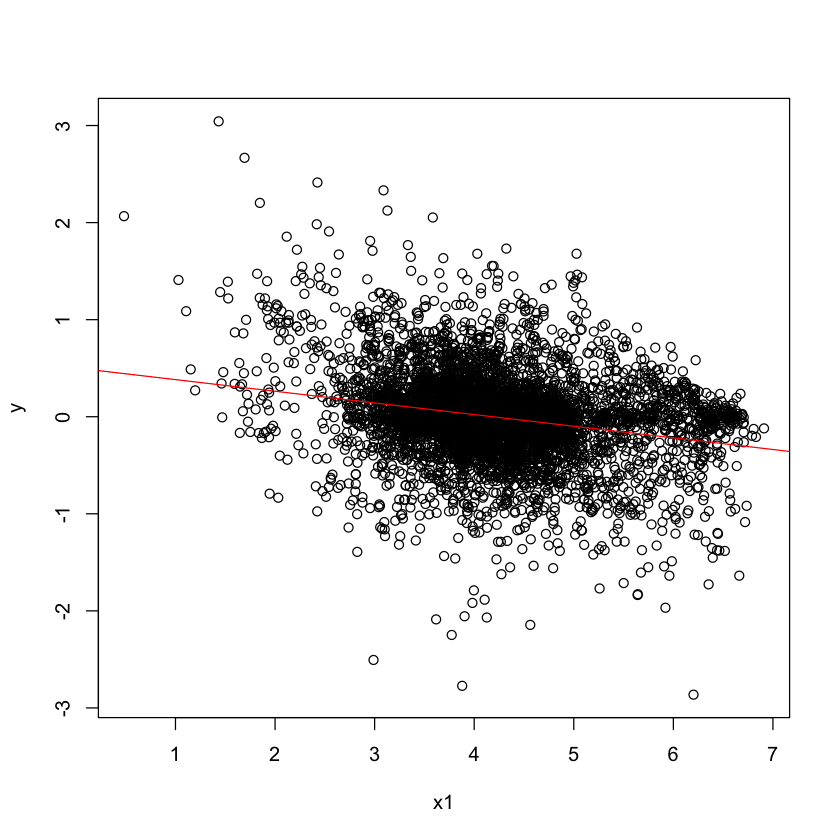

In [23]:
plot(x1,y)
abline(fit_clewlow, col="red")

In [24]:
kappa_0 <- summary(fit_clewlow)$coefficients["(Intercept)", "Estimate"]
kappa_1 <- summary(fit_clewlow)$coefficients["x1", "Estimate"]

# kappa is the mean reverting velocity 
kappa <- -kappa_1/dt
kappa

[1] 43.87718

In [25]:
# alpha is the value of long term reverting
alpha <- kappa_0 / (kappa*dt)
alpha
exp(alpha)

[1] 4.193029

[1] 66.22309

In [26]:
# sigma is the volatility of the process
sigma_clewlow <- sigma(fit_clewlow)
sigma_clewlow_yearly <- sigma_clewlow/((dt)^(1/2))
sigma_clewlow_yearly

[1] 7.72443




MÉTODO 2 >> ** Vasicek usando la función "fitsde" de la libreria "Sim.DiffProc" **

A continuación usaremos la biblioteca "Sim.DiffProc" que tiene varias funciones para el ajuste y simulación de "Diffusion Processes". Como podrán revisar en la web de esta biblioteca (https://cran.r-project.org/web/packages/Sim.DiffProc/) el proceso de difusión es dividido en dos partes: i) una parte determinística llamada de "drift"; y ii) una parte estocástica llamada de "diffusion".

La función "fitsde" recibe además de la data de la variable a modelar, la forma de la función determinística a través del parámetro "drift", y la forma de la función estocástica a través del parámetro "diffusion".

$ dX = kappa*(alpha - X)*dt + sigma*dW  $

$ dX =[ kappa*alpha - kappa*X ]*dt + sigma*dW $

In [27]:
mydata_1 <- ts(v_log_P, start = data_cmg$Time[1], deltat = 1/365)

fx_1 <- expression(theta[1]-theta[2]*x)
gx_1 <- expression(theta[3])
fitmod_1 <- fitsde(data=mydata_1, drift = fx_1, diffusion = gx_1, start = list(theta1=1, theta2=1, theta3=1), pmle = "euler")
fitmod_1
summary(fitmod_1)


Call:
fitsde(data = mydata_1, drift = fx_1, diffusion = gx_1, start = list(theta1 = 1, 
    theta2 = 1, theta3 = 1), pmle = "euler")

Coefficients:
    theta1     theta2     theta3 
183.978237  43.877166   7.723317 

Pseudo maximum likelihood estimation

Method:  Euler
Call:
fitsde(data = mydata_1, drift = fx_1, diffusion = gx_1, start = list(theta1 = 1, 
    theta2 = 1, theta3 = 1), pmle = "euler")

Coefficients:
         Estimate Std. Error
theta1 183.978237 8.86667242
theta2  43.877166 2.07402881
theta3   7.723317 0.06556494

-2 log L: 7121.631 


In [37]:
kappa_new <- fitmod_1$coef[[2]]
kappa_new # velocidad de reversión al valor medio de largo plazo

[1] 43.87717

In [38]:
alpha_new <- fitmod_1$coef[[1]]/kappa_new
alpha_new # valor medio de largo plazo al cual revierte el proceso (en logaritmo)
exp(alpha_new) # valor medio de largo plazo al cual revierte el proceso en unidades monetarias por MWh

[1] 4.193029

[1] 66.22309

Nótese que los valores obtenidos de los parámetros de la ecuación diferencial estocástica son los mismos con ambos métodos.

Ahora realizaremos un gráfico de back-testing del modelo encontrado, usando simulación Monte Carlo para crear una nube de caminos aleatorios que el proceso de difusión calibrado nos indica.

In [42]:
theta <- coef(fitmod_1) # carga los parámetros del modelo encontrado en el vector "theta" de este modo
                        # las funciones fx_1 (drift) y gx_1 (diffusion) ya están determinadas por esos valores
                        # de theta[1], theta[2] y theta[3]

N = length(mydata_1)

res <- snssde1d(
  drift = fx_1,
  diffusion = gx_1,
  x0=mydata_1[1],
  M=500,
  N=length(mydata_1),
  t0 = time(mydata_1)[1],
  T = time(mydata_1)[N]
)

Graficaremos la serie histórica de datos y además tres puntos por cada paso del camino aleatorio creado con Monte Carlo: i) el valor medio en color verde claro; ii) el valor inferior del intervalo de confianza al 95%; y iii) el valor superior del intervalo de confianza al 95%.  

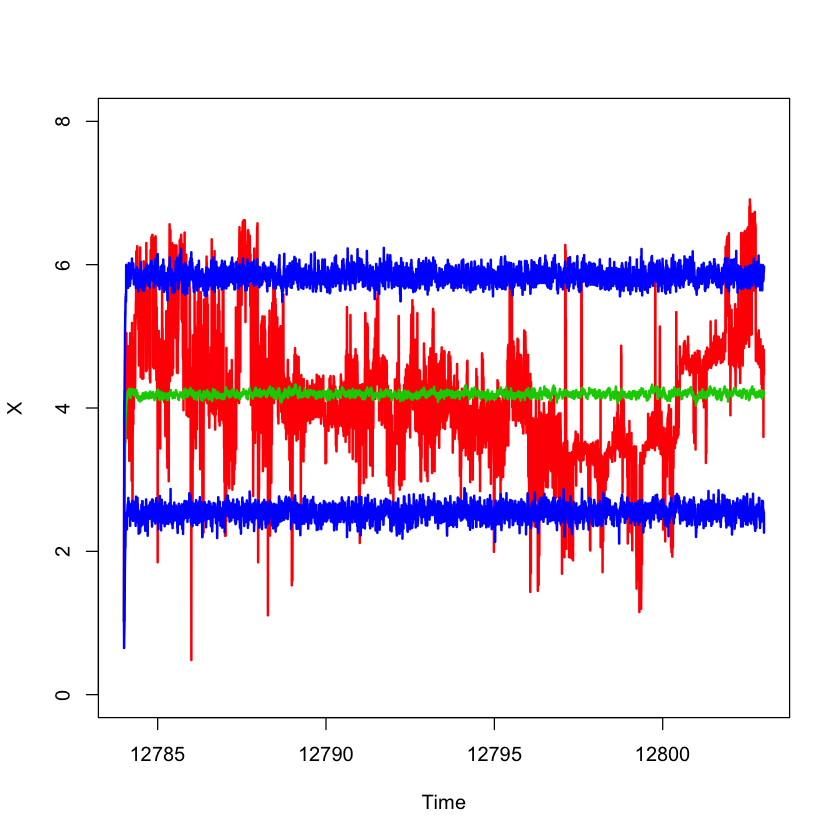

In [40]:
plot(res, type="n", ylim=c(0,8))
lines(mydata_1,col=2,lwd=2)
lines(time(res),apply(res$X,1,mean),col=3, lwd=2)
lines(time(res),apply(res$X,1,bconfint,level=0.95)[1,],col=4,lwd=2)
lines(time(res),apply(res$X,1,bconfint,level=0.95)[2,],col=4,lwd=2)

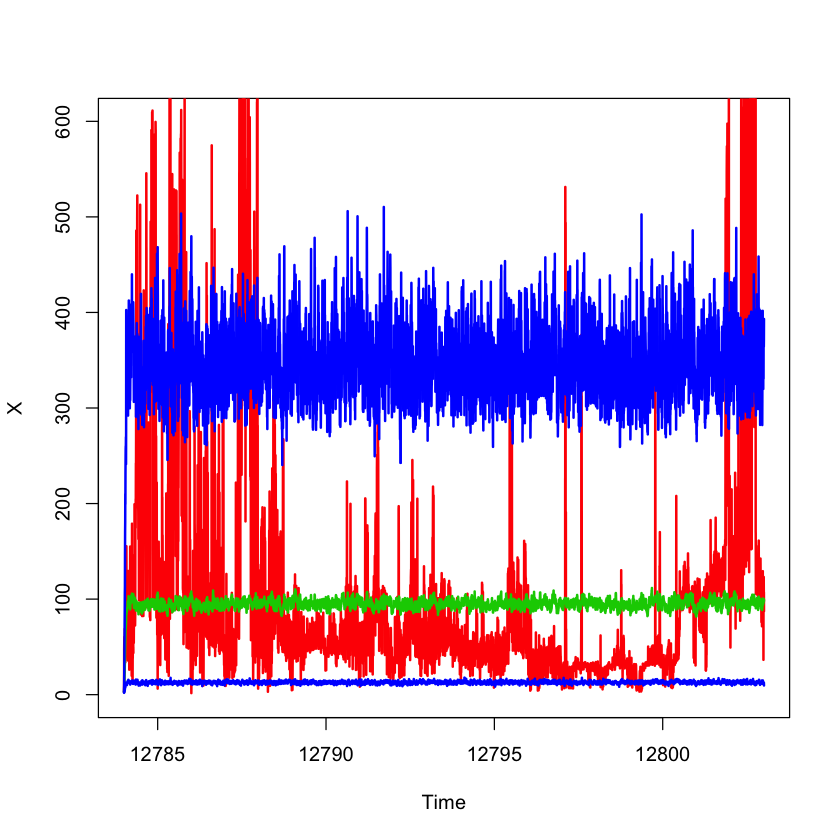

In [41]:
plot(res, type="n", ylim=c(0,600))
lines(exp(mydata_1),col=2,lwd=2)
lines(time(res),apply(exp(res$X),1,mean),col=3, lwd=2)
lines(time(res),apply(exp(res$X),1,bconfint,level=0.95)[1,],col=4,lwd=2)
lines(time(res),apply(exp(res$X),1,bconfint,level=0.95)[2,],col=4,lwd=2)

Calibración del Modelo Cox-Ingersol-Ross (reversión a un valor medio con volatilidad variable)
===

Otro modelo que vamos a analizar es el de Cox-Ingersol-Ross que en la parte determinística es igual al de Vasicek, pero en la parte estocástica incorpora una volatilidad que varía con la raíz cuadrada de la variable.

$ dX = kappa*(alpha - X)*dt + sigma*sqrt(X)*dW $

$ dX =[ kappa*alpha - kappa*X ]*dt + sigma*sqrt(X)*dW $

In [44]:
mydata_1 <- ts(v_log_P, start = data_cmg$Time[1], deltat = 1/365)

fx_1 <- expression(theta[1]-theta[2]*x)
gx_1 <- expression(theta[3]*sqrt(x))
fitmod_1 <- fitsde(data=mydata_1, drift = fx_1, diffusion = gx_1, start = list(theta1=1, theta2=1, theta3=1), pmle = "euler")
fitmod_1
summary(fitmod_1)


Call:
fitsde(data = mydata_1, drift = fx_1, diffusion = gx_1, start = list(theta1 = 1, 
    theta2 = 1, theta3 = 1), pmle = "euler")

Coefficients:
    theta1     theta2     theta3 
236.157502  56.333706   3.987934 

Pseudo maximum likelihood estimation

Method:  Euler
Call:
fitsde(data = mydata_1, drift = fx_1, diffusion = gx_1, start = list(theta1 = 1, 
    theta2 = 1, theta3 = 1), pmle = "euler")

Coefficients:
         Estimate Std. Error
theta1 236.157502 8.72876852
theta2  56.333706 2.13116995
theta3   3.987934 0.03385445

-2 log L: 7740.296 


Ahora realizaremos un gráfico de back-testing del modelo encontrado, usando simulación Monte Carlo para crear una nube de caminos aleatorios que el proceso de difusión calibrado (CIR) nos indica.

In [47]:
theta <- coef(fitmod_1) # carga los parámetros del modelo encontrado en el vector "theta" de este modo
                        # las funciones fx_1 (drift) y gx_1 (diffusion) ya están determinadas por esos valores
                        # de theta[1], theta[2] y theta[3]

N = length(mydata_1)

res <- snssde1d(
  drift = fx_1,
  diffusion = gx_1,
  x0=mydata_1[1],
  M=500,
  N=length(mydata_1),
  t0 = time(mydata_1)[1],
  T = time(mydata_1)[N]
)

Graficaremos la serie histórica de datos y además tres puntos por cada paso del camino aleatorio creado con Monte Carlo: i) el valor medio en color verde claro; ii) el valor inferior del intervalo de confianza al 95%; y iii) el valor superior del intervalo de confianza al 95%.

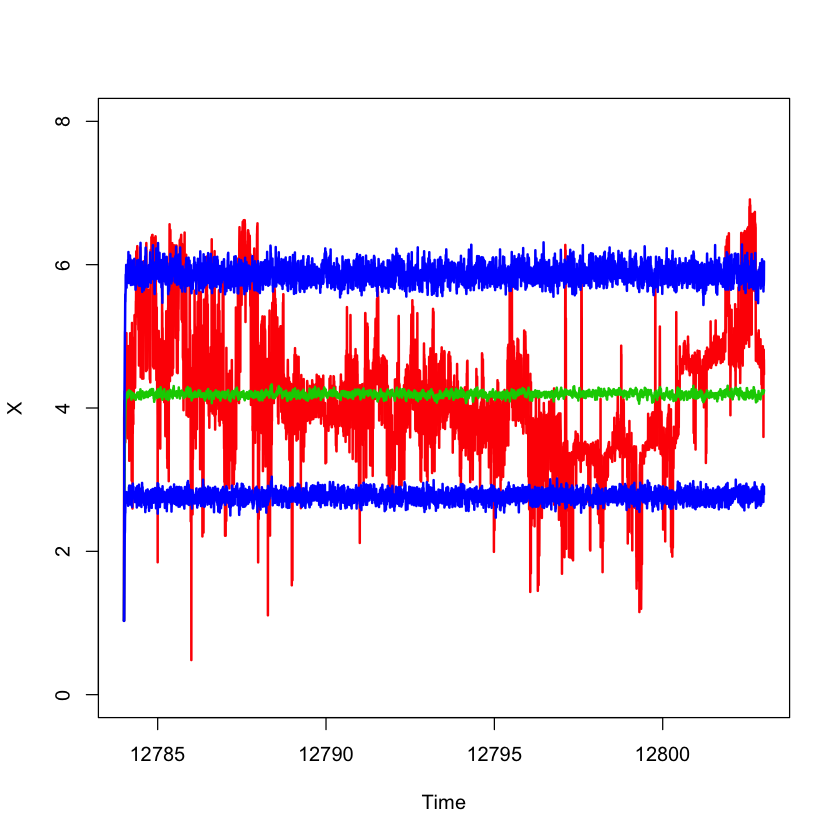

In [46]:
plot(res, type="n", ylim=c(0,8))
lines(mydata_1,col=2,lwd=2)
lines(time(res),apply(res$X,1,mean),col=3, lwd=2)
lines(time(res),apply(res$X,1,bconfint,level=0.95)[1,],col=4,lwd=2)
lines(time(res),apply(res$X,1,bconfint,level=0.95)[2,],col=4,lwd=2)

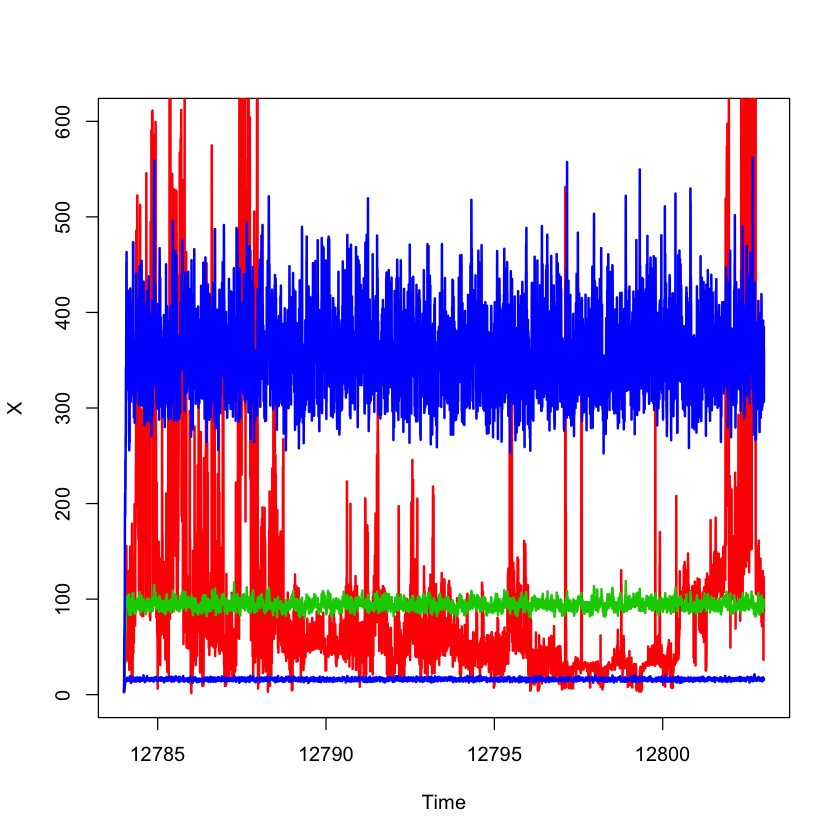

In [48]:
plot(res, type="n", ylim=c(0,600))
lines(exp(mydata_1),col=2,lwd=2)
lines(time(res),apply(exp(res$X),1,mean),col=3, lwd=2)
lines(time(res),apply(exp(res$X),1,bconfint,level=0.95)[1,],col=4,lwd=2)
lines(time(res),apply(exp(res$X),1,bconfint,level=0.95)[2,],col=4,lwd=2)

Calibración del Modelo Lucia & Schwartz, 2000 (Reversión a un valor medio con hidrología sinusoidal en la parte determinística)
===

De acuerdo con el paper de Lucia & Schwartz (2000) uno de los modelos plausibles a utilizar es el de reversión a un valor medio con estacionalidad sinusoidal en la parte determinística.

Los autores proponen utilizar una forma sinusoidal que represente el ciclo anual estacional de los precios, con una función determinística dependiente del tiempo, del tipo:

$ f(t) = alpha + gamma*cos((t+tao)*2*pi/365) $

Analizaremos primero el comportamiento de esta función determinística para representar los ciclos hidrológicos de avenida y estiajes que se reflejan en los precios spot.

In [51]:
Time_dat <- data_cmg$Time 
x_dat <- as.double(data_cmg$Time)
y_dat <- data_cmg$Price
Year_dat <- data_cmg$Year
Estiaje <- data_cmg$Estiaje

In [52]:
ds <- data.frame(Time = Time_dat, t = x_dat, Price= y_dat, Year = Year_dat, Estiaje = Estiaje)

str(ds)

f_determ <- function(t,alpha,gamma,Tao) {
  (alpha + gamma*cos((t+Tao)*2*pi/365))
}

'data.frame':	6939 obs. of  5 variables:
 $ Time   : Date, format: "2005-01-01" "2005-01-02" ...
 $ t      : num  12784 12785 12786 12787 12788 ...
 $ Price  : num  2.8 11.5 48.3 56.7 60.5 ...
 $ Year   : num  2005 2005 2005 2005 2005 ...
 $ Estiaje: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...


In [53]:
model1 <- nls(Price ~ f_determ(t,my_alpha,my_gamma,my_Tao), # usamos un ajuste de mínimos cuadrados no lineal
              data=ds,
              start = list(my_alpha=1, my_gamma=1, my_Tao=1)
)

summary(model1)

fit_Price <- predict(model1)


Formula: Price ~ f_determ(t, my_alpha, my_gamma, my_Tao)

Parameters:
         Estimate Std. Error t value Pr(>|t|)    
my_alpha  100.397      1.438   69.83   <2e-16 ***
my_gamma  -46.172      2.033  -22.71   <2e-16 ***
my_Tao   2134.485      2.558  834.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119.8 on 6936 degrees of freedom

Number of iterations to convergence: 8 
Achieved convergence tolerance: 2.156e-07


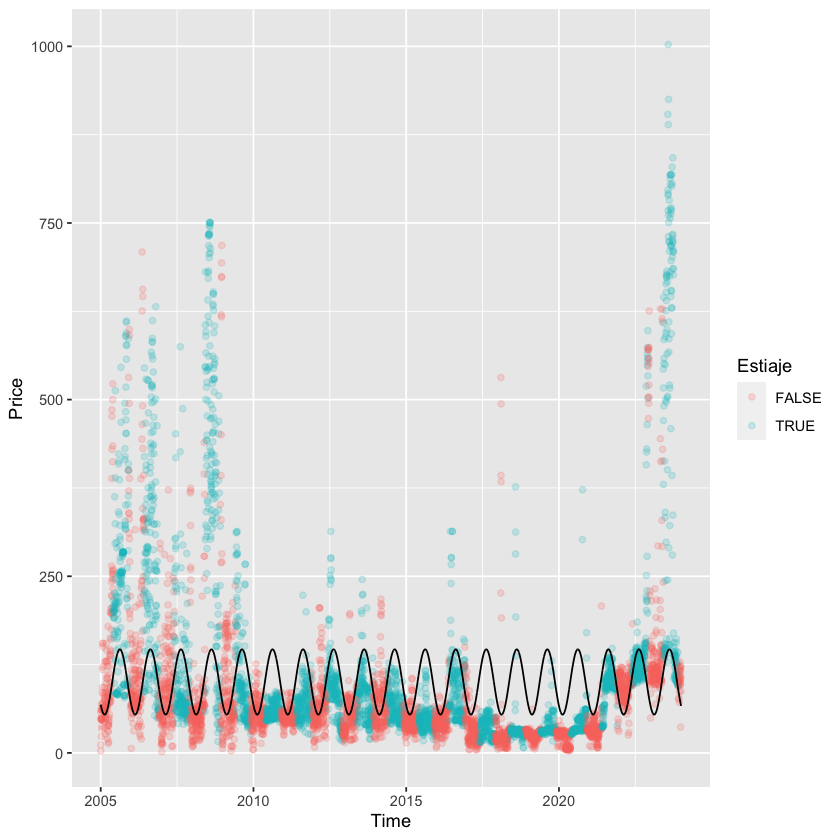

In [54]:
ds %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price))

En el gráfico notamos que el ciclo de la función sinusoidal determinística refleja apropiadamente el ciclo anual en el que los precios son altos en estiaje en comparación con los precios bajos en temporada de avenida.

Ahora procedamos a calibrar el modelo que incluye la parte determinística y la parte estocástica, usando la función "fitsde" de la biblioteca "Sim.DiffProc". Nótese que estamos trabajando con la ecuación 16 del paper Lucia & Schwartz (2000), página 14.

$ dP = kappa*(b(t) - ln(P))*P*dt + sigma*P*dW $

$ b(t) = 1/kappa*( 1/2*sigma^2 + df(t)/dt) + f(t) $

In [55]:
fx <- expression(1/2*theta[5]^2 - 2*pi/365*theta[1]*sin((t+theta[2])*2*pi/365)
                 + theta[3] + theta[4]*(theta[1]*cos((t+theta[2])*2*pi/365) - x))
gx <- expression(theta[5])

mydata <- ts(log(data_cmg$Price), start = data_cmg$Time[1], deltat = 1/365)

fitmod <- fitsde(data=mydata, drift = fx, diffusion = gx, start = list(theta1=1, theta2=1, theta3=1, theta4=1, theta5=1), pmle = "euler")
fitmod
summary(fitmod)


Call:
fitsde(data = mydata, drift = fx, diffusion = gx, start = list(theta1 = 1, 
    theta2 = 1, theta3 = 1, theta4 = 1, theta5 = 1), pmle = "euler")

Coefficients:
    theta1     theta2     theta3     theta4     theta5 
  3.769701 133.418876 311.790167  46.007299   7.728615 

Pseudo maximum likelihood estimation

Method:  Euler
Call:
fitsde(data = mydata, drift = fx, diffusion = gx, start = list(theta1 = 1, 
    theta2 = 1, theta3 = 1, theta4 = 1, theta5 = 1), pmle = "euler")

Coefficients:
         Estimate  Std. Error
theta1   3.769701  1.06323035
theta2 133.418876 11.57902510
theta3 311.790167 51.80557868
theta4  46.007299  2.27639763
theta5   7.728615  0.06596059

-2 log L: 7088.605 


In [56]:
theta <- coef(fitmod)

N = length(mydata)

res <- snssde1d(
  drift = fx,
  diffusion = gx,
  x0=mydata[1],
  M=500,
  N=length(mydata),
  t0 = time(mydata)[1],
  T = time(mydata)[N]
)

Graficaremos la serie histórica de datos y además tres puntos por cada paso del camino aleatorio creado con Monte Carlo: i) el valor medio en color verde claro; ii) el valor inferior del intervalo de confianza al 95%; y iii) el valor superior del intervalo de confianza al 95%.

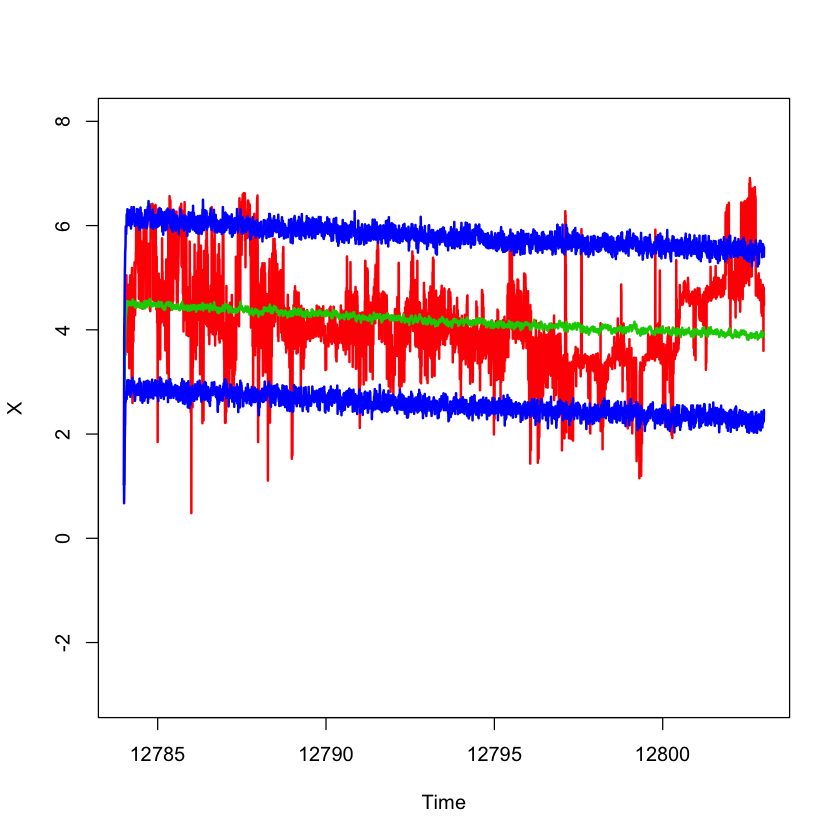

In [57]:
plot(res, type="n", ylim=c(-3,8))
lines(mydata,col=2,lwd=2)
lines(time(res),apply(res$X,1,mean),col=3, lwd=2)
lines(time(res),apply(res$X,1,bconfint,level=0.95)[1,],col=4,lwd=2)
lines(time(res),apply(res$X,1,bconfint,level=0.95)[2,],col=4,lwd=2)

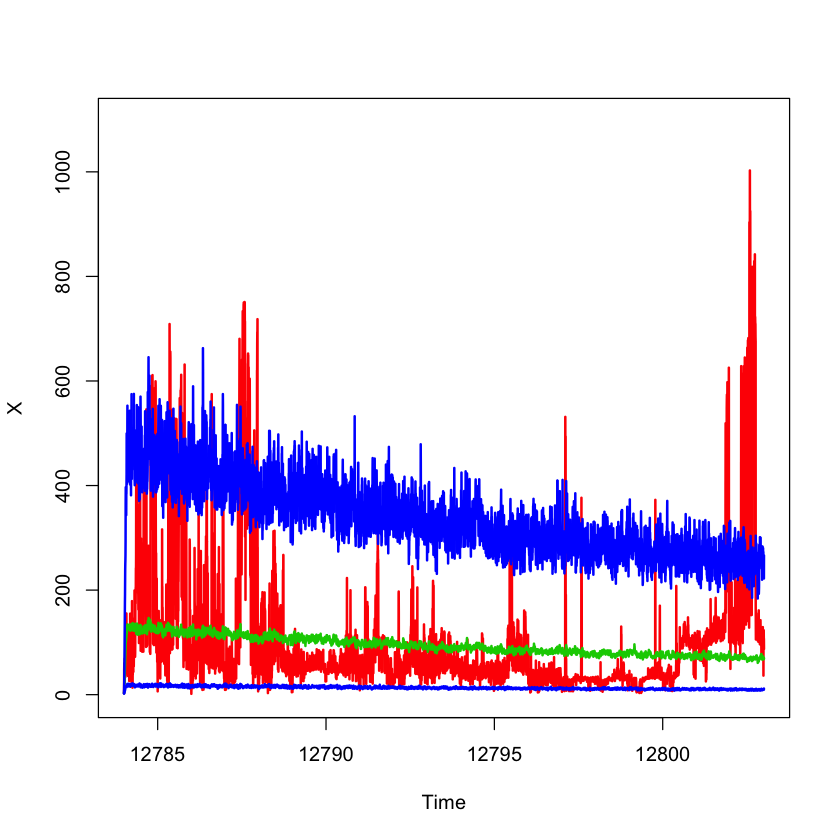

In [58]:
plot(res, type="n", ylim=c(0,exp(7)))
lines(exp(mydata),col=2,lwd=2)
lines(time(res),apply(exp(res$X),1,mean),col=3, lwd=2)
lines(time(res),apply(exp(res$X),1,bconfint,level=0.95)[1,],col=4,lwd=2)
lines(time(res),apply(exp(res$X),1,bconfint,level=0.95)[2,],col=4,lwd=2)

Veamos cómo luce el back-testing si trabajamos con la ventana de datos del 2020 al 2023

In [61]:
fx <- expression(1/2*theta[5]^2 - 2*pi/365*theta[1]*sin((t+theta[2])*2*pi/365)
                 + theta[3] + theta[4]*(theta[1]*cos((t+theta[2])*2*pi/365) - x))
gx <- expression(theta[5])

ventana <- data_cmg %>%
  select(Price, Time, Year) %>%
  filter(Year >= 2020)

mydata <- ts(log(ventana$Price), start = ventana$Time[1], deltat = 1/365)

fitmod <- fitsde(data=mydata, drift = fx, diffusion = gx, start = list(theta1=1, theta2=1, theta3=1, theta4=1, theta5=1), pmle = "euler")
fitmod
summary(fitmod)


Call:
fitsde(data = mydata, drift = fx, diffusion = gx, start = list(theta1 = 1, 
    theta2 = 1, theta3 = 1, theta4 = 1, theta5 = 1), pmle = "euler")

Coefficients:
    theta1     theta2     theta3     theta4     theta5 
 39.758635 -99.788467  17.563836  57.282676   6.129567 

Pseudo maximum likelihood estimation

Method:  Euler
Call:
fitsde(data = mydata, drift = fx, diffusion = gx, start = list(theta1 = 1, 
    theta2 = 1, theta3 = 1, theta4 = 1, theta5 = 1), pmle = "euler")

Coefficients:


Warning message in sqrt(diag(vcov)):
“NaNs produced”


         Estimate Std. Error
theta1  39.758635        NaN
theta2 -99.788467        NaN
theta3  17.563836        NaN
theta4  57.282676   5.111648
theta5   6.129567   0.113205

-2 log L: 823.7745 


In [62]:
theta <- coef(fitmod)

N = length(mydata)

res <- snssde1d(
  drift = fx,
  diffusion = gx,
  x0=mydata[1],
  M=500,
  N=length(mydata),
  t0 = time(mydata)[1],
  T = time(mydata)[N]
)

Graficaremos la serie histórica de datos y además tres puntos por cada paso del camino aleatorio creado con Monte Carlo: i) el valor medio en color verde claro; ii) el valor inferior del intervalo de confianza al 95%; y iii) el valor superior del intervalo de confianza al 95%.

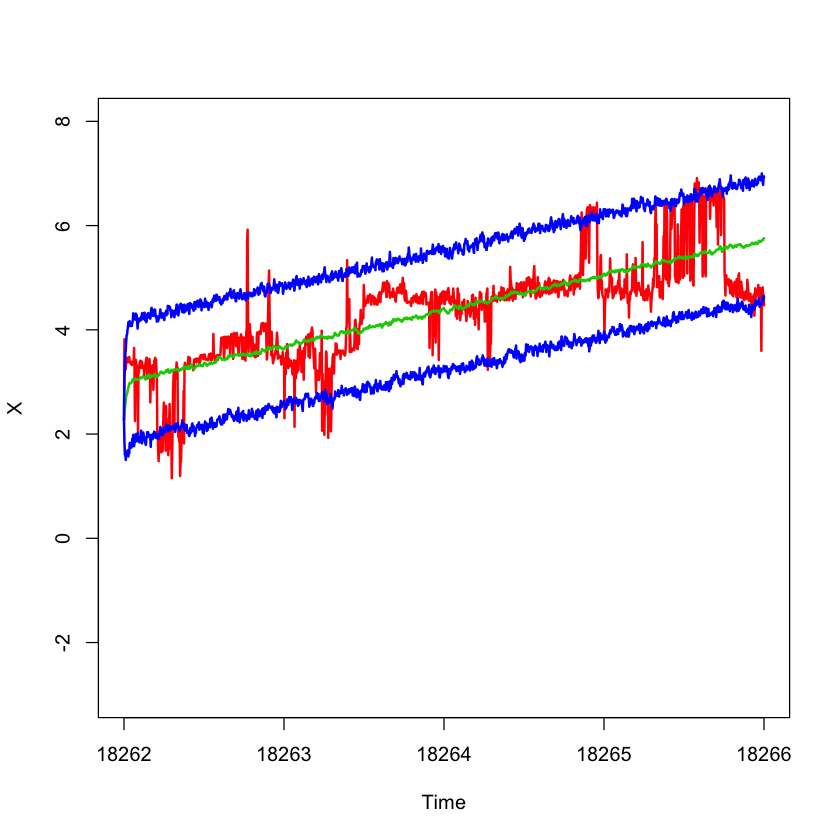

In [63]:
plot(res, type="n", ylim=c(-3,8))
lines(mydata,col=2,lwd=2)
lines(time(res),apply(res$X,1,mean),col=3, lwd=2)
lines(time(res),apply(res$X,1,bconfint,level=0.95)[1,],col=4,lwd=2)
lines(time(res),apply(res$X,1,bconfint,level=0.95)[2,],col=4,lwd=2)

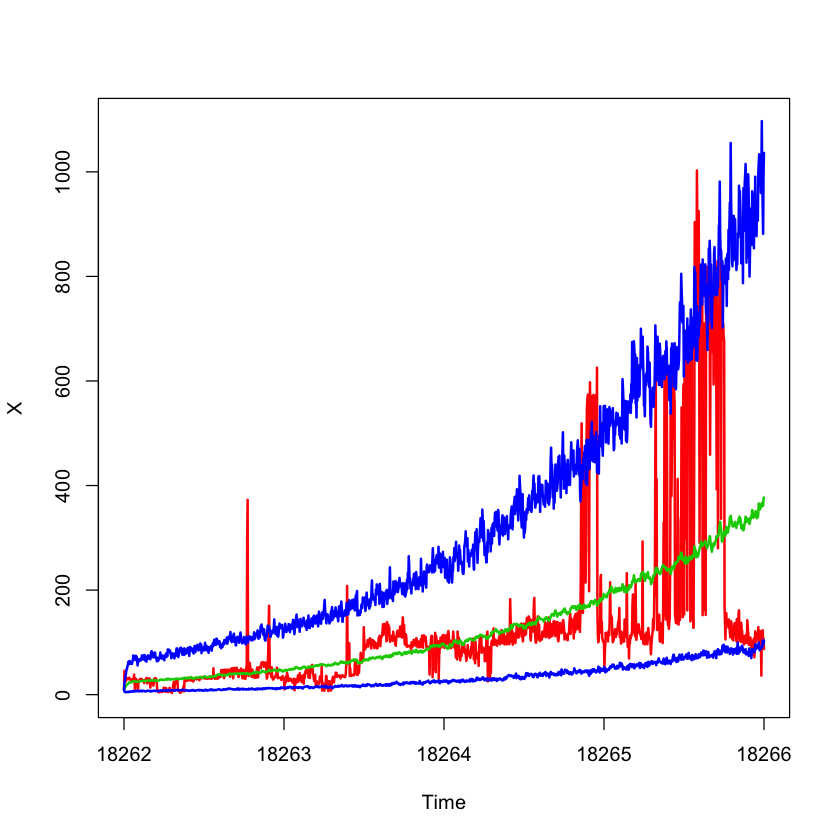

In [64]:
plot(res, type="n", ylim=c(0,exp(7)))
lines(exp(mydata),col=2,lwd=2)
lines(time(res),apply(exp(res$X),1,mean),col=3, lwd=2)
lines(time(res),apply(exp(res$X),1,bconfint,level=0.95)[1,],col=4,lwd=2)
lines(time(res),apply(exp(res$X),1,bconfint,level=0.95)[2,],col=4,lwd=2)